# AI Training with all models 


In [1]:
#Imports:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import autokeras as ak
import xgboost as xgb
import catboost as cat
import pickle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
from imblearn.over_sampling import SMOTE 
from tensorflow.keras.models import load_model
from sklearn.utils import resample,shuffle
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn import neural_network
from sklearn.utils import resample
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler


In [2]:
# Methods to test the predictions

def count_points(pred, gold):
    df = pd.merge(pred, gold, on=['userID', 'itemID'], suffixes=('_pred', '_gold'))
    df['points'] = df.apply(_compute_points_for_row, axis=1)
    return df['points'].sum()

def _compute_points_for_row(row):
    y_pred, y_gold = row.prediction_pred, row.prediction_gold
    if y_pred == y_gold:
        # one point if "no order" (0) is predicted correctly; three points if order week is predicted correctly
        return 1 if y_pred == 0 else 3
    # one point if order is predicted correctly (but not the correct week), otherwise zero points
    return 1 if (y_pred > 0 and y_gold > 0) else 0

def preprocessData(df, preprocess = True):
    labels = to_label(df["label"]) # generating a label dataset
    df = df.drop(['label'], axis = 1) #dropping label
    df = df.drop(['order'], axis = 1) #dropping order
    df = df.drop(['date'], axis = 1) #dropping date
    data = df
    enc = OneHotEncoder(handle_unknown='ignore') #onehotencoder
    if preprocess:
        cols = ["feature_1", "feature_2", "feature_4"] #columns to onehot encode
        enc.fit(data[cols])
        encoder_df = pd.DataFrame(enc.transform(data[cols]).toarray()) #encoding
        data = data[["userID", "itemID", "brand", "feature_3", "feature_5" 
                     #,]].join(encoder_df) #merging
                    ,"user_total_purchase_time", "user_total_orders","item_total_purchase_time","item_total_orders",
                     "weekday","date_of_month", "month", "category"]].join(encoder_df) #merging
    lb = preprocessing.LabelBinarizer()
    #lenc = enc.fit(np_labels)
    lb = lb.fit(labels.to_numpy())
    labels_enc = lb.transform(labels.to_numpy())
    
    return labels_enc, data, lb, enc

def to_label(pre):
    newLabels = []
    for i in pre.to_numpy():
        if i <= 0 or i > 28:
            newLabels.append(0)
        elif i <=7:
            newLabels.append(1) 
        elif i <=14:
            newLabels.append(2) 
        elif i <=21:
            newLabels.append(3)
        else:
            newLabels.append(4)
            
    return pd.DataFrame(newLabels)

In [3]:
#train_dec = pd.read_csv("train_bef_dec.csv")
train_dec = pd.read_csv("Data/item_orders_bef_jan.csv", sep = ",")
print(len(train_dec))
#df_items = pd.read_csv("items.csv", sep = "|") #items

#train_dec = pd.merge(train_dec, df_items, on="itemID") #merging the dataset on itemID 

train_dec.head()

y_train, x_train, binarizer, enc = preprocessData(train_dec, True)

x_train.head()


1048575


,userID,itemID,brand,feature_3,feature_5,user_total_purchase_time,user_total_orders,item_total_purchase_time,item_total_orders,weekday,...,12,13,14,15,16,17,18,19,20,21
0,0,1505,286,82,144,2.0,2.0,9.14,9.29,1,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0,6446,839,18,81,2.0,2.0,7.00,7.14,4,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0,9325,107,308,17,2.0,2.0,27.29,35.57,4,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0,12468,1288,421,3,2.0,2.0,6.86,7.86,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0,12505,53,474,-1,2.0,2.0,45.57,45.86,1,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0


In [4]:
#pred_dec = pd.read_csv("Data/sub_final_.csv")
##test_dec = test_dec.sort_values(by=["userID"])
#y_train, x_train, binarizer, enc = preprocessData(train_dec, )
#print(len(test_dec))
#
#pred_dec.sort_values("userID").head()

In [5]:
pred_dec = pd.read_csv("Data/sub_final_jan_9545.csv", sep = ",")
#pred_dec = pd.merge(pred_dec, train_dec, on=["userID", "itemID"], how = "inner") #rging the dataset on itemID 
print(len(pred_dec))
pred_dec.sort_values("userID").head()

9940


,userID,itemID,date,brand,feature_1,feature_2,feature_3,feature_4,feature_5,category,order,user_total_purchase_time,user_total_orders,item_total_purchase_time,item_total_orders,weekday,date_of_month,month,label,prediction
0,0,20664,2020-12-11 00:00:00,408.0,4.0,0.0,284.0,0.0,66.0,3898.0,1.0,2.00,2.00,23.00,23.29,4.0,11.0,12.0,0.0,0.0
1,0,28231,2020-12-11 00:00:00,193.0,4.0,3.0,468.0,3.0,108.0,3898.0,1.0,2.00,2.00,5.14,6.57,4.0,11.0,12.0,0.0,0.0
2,13,2690,2020-12-24 00:00:00,406.0,4.0,3.0,491.0,0.0,66.0,3898.0,1.0,6.43,8.86,0.57,0.57,3.0,24.0,12.0,0.0,0.0
3,15,1299,2020-12-26 00:00:00,1056.0,4.0,0.0,474.0,-1.0,108.0,3898.0,1.0,5.14,6.29,17.14,26.86,5.0,26.0,12.0,0.0,0.0
4,15,20968,2020-12-26 00:00:00,1315.0,4.0,0.0,444.0,0.0,144.0,3915.0,1.0,5.14,6.29,37.57,40.14,5.0,26.0,12.0,0.0,0.0


In [6]:
name = 'submission_jan'

#df_submission = pd.read_csv( name+".csv", sep = "|")
#
#result_pred = pd.merge(df_submission, df_items, on="itemID")
#
#result_pred = result_pred.drop(['categories'], axis = 1)
data = pred_dec.drop(['prediction'], axis = 1)
cols = ["feature_1", "feature_2", "feature_4"]

encoder_df = pd.DataFrame(enc.transform(data[cols]).toarray())
submission = data[["userID", "itemID", "brand", "feature_3", "feature_5" 
                     #,]].join(encoder_df) #merging
                    ,"user_total_purchase_time", "user_total_orders","item_total_purchase_time","item_total_orders",
                     "weekday","date_of_month", "month", "category"]].join(encoder_df) #merging

submission.sort_values("userID")

,userID,itemID,brand,feature_3,feature_5,user_total_purchase_time,user_total_orders,item_total_purchase_time,item_total_orders,weekday,...,12,13,14,15,16,17,18,19,20,21
0,0,20664,408.0,284.0,66.0,2.00,2.00,23.00,23.29,4.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0,28231,193.0,468.0,108.0,2.00,2.00,5.14,6.57,4.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,13,2690,406.0,491.0,66.0,6.43,8.86,0.57,0.57,3.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
3,15,1299,1056.0,474.0,108.0,5.14,6.29,17.14,26.86,5.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,15,20968,1315.0,444.0,144.0,5.14,6.29,37.57,40.14,5.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9935,46118,20106,1111.0,491.0,66.0,5.86,9.43,27.29,33.14,2.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
9936,46124,19677,1006.0,491.0,154.0,3.86,4.00,10.71,12.71,4.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
9937,46125,12878,1111.0,491.0,66.0,1.71,1.86,7.43,7.71,6.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
9938,46127,7963,1111.0,485.0,154.0,3.57,5.14,8.57,10.29,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [7]:
#sm = SMOTE(random_state=42)

X_train, X_test, y_train, y_test= train_test_split(x_train, y_train, test_size=0.6, random_state=42)

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

ros = RandomOverSampler(sampling_strategy ="all" ,random_state=42)

X_train, y_train = ros.fit_resample(X_train, y_train)

#X_train, y_train =  sm.fit_resample(X_train, y_train)

X_train, X_val, y_train, y_val= train_test_split(X_train, y_train, test_size=0.3, random_state=42)

print(len(X_train.shape), len(X_test.shape), len(X_val.shape))


C:\Users\knabp_000\anaconda3\envs\Envi\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


2 2 2


In [8]:
X_train_arr = X_train.to_numpy()
X_val_arr = X_val.to_numpy()
X_test_arr = X_test.to_numpy()

y_val_n = binarizer.inverse_transform(y_val)
y_train_n = binarizer.inverse_transform(y_train)
y_test_n = binarizer.inverse_transform(y_test)

In [9]:
len(X_train_arr)

1370736

## Models

In [57]:
# Autokeras
model = ak.AutoModel(
    inputs=[ak.StructuredDataInput()],
    outputs=[ak.ClassificationHead()],
    max_trials=3,
    overwrite = True
)

model.fit(
    x=X_train_arr, y=y_train, epochs=50, batch_size=128, validation_data= [X_val_arr, y_val]
)


res_train_ak = model.predict(X_train_arr)
res_test_ak = model.predict(X_test_arr)
res_val_ak = model.predict(X_val_arr)


model = model.export_model()


try:
    model.save("model_autokeras_jan_class", save_format="tf")
except Exception:
    model.save("model_autokeras_jan_class.h5")

Trial 3 Complete [00h 18m 05s]
val_loss: 1.107924461364746

Best val_loss So Far: 1.0793061256408691
Total elapsed time: 00h 46m 38s
INFO:tensorflow:Oracle triggered exit
Epoch 1/50
10709/10709 [==============================] - 19s 2ms/step - loss: 1.9680 - accuracy: 0.4297 - val_loss: 1.1866 - val_accuracy: 0.4583
Epoch 2/50
10709/10709 [==============================] - 18s 2ms/step - loss: 1.1580 - accuracy: 0.4789 - val_loss: 1.1427 - val_accuracy: 0.4850
Epoch 3/50
10709/10709 [==============================] - 19s 2ms/step - loss: 1.1268 - accuracy: 0.4947 - val_loss: 1.1156 - val_accuracy: 0.4992
Epoch 4/50
10709/10709 [==============================] - 18s 2ms/step - loss: 1.1118 - accuracy: 0.5007 - val_loss: 1.1092 - val_accuracy: 0.4955
Epoch 5/50
10709/10709 [==============================] - 18s 2ms/step - loss: 1.1028 - accuracy: 0.5032 - val_loss: 1.1055 - val_accuracy: 0.4959
Epoch 6/50
10709/10709 [==============================] - 18s 2ms/step - loss: 1.0969 - accura

In [25]:
model = load_model("model_autokeras_dec_class", custom_objects=ak.CUSTOM_OBJECTS)

In [26]:
res = model.predict(X_test_arr)

In [28]:
res = binarizer.inverse_transform(res)
res
y_train_n 
print(classification_report(y_test_n,res))

              precision    recall  f1-score   support

           0       0.98      0.84      0.90    587785
           1       0.07      0.30      0.11      4561
           2       0.09      0.31      0.14      8876
           3       0.09      0.27      0.14     12643
           4       0.10      0.22      0.13     15280

    accuracy                           0.80    629145
   macro avg       0.26      0.39      0.28    629145
weighted avg       0.92      0.80      0.85    629145



In [58]:
def baseline(classifier,x_train_dt,x_test_dt,y_train_dt,y_test_dt):
    baseline=classifier
    baseline.fit(x_train_dt,y_train_dt)
    stratified_10_fold_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    pred=baseline.predict(x_test_dt)
    print('CV score with default parameters:{}'.format(cross_val_score(classifier,x_train_dt, y_train_dt, cv=stratified_10_fold_cv, scoring='accuracy').mean()))
    print('classification_report on test set with default parameters:\n')
    print(classification_report(y_test_dt,pred))
    # cnf_matrix = confusion_matrix(y_test_dt,pred)    
    #np.set_printoptions(precision=2)
   # plot_confusion_matrix(cnf_matrix,classes=labels,title='confusion matrix:default')
    return baseline


def naivebayes (x_train,x_test,y_train,y_test):
    gnb=GaussianNB()
    gnb.fit(x_train, y_train)
    stratified_10_fold_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    accuracy=cross_val_score(gnb,x_train,y_train,cv=cv)
    print('Mean CV score is: {}'.format(accuracy.mean()))
    params_NB = {'var_smoothing': np.logspace(0,-9, num=100)}
    grid_search = GridSearchCV( estimator=gnb,param_grid=params_NB, cv=cv,verbose=1, scoring='accuracy') 
    grid_search.fit(x_train, y_train)
    print("The best parameter is:{}".format(grid_search.best_params_))
    print("The best validation score is:{}".format(grid_search.best_score_))
    gnb.set_params(var_smoothing=grid_search.best_params_)
    prediction = gnb.predict(x_test)
    print(classification_report(y_test, prediction))
    cm=confusion_matrix(y_test,prediction)    
    
    return gnb

def decisionTree(x_train,x_test,y_train,y_test):
    
    parameters={
            'criterion':['gini','entropy'],
            'max_depth':[2,3,4,5,6,7,8]
            }
    dtree=DecisionTreeClassifier()
    stratified_10_fold_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    
    grid_search=GridSearchCV(dtree,parameters,scoring='accuracy',cv=stratified_10_fold_cv)
    grid_search.fit(x_train,y_train) 
    print('CV score with best parameters:{}'.format(cross_val_score(grid_search.best_estimator_,x_train, y_train, cv=stratified_10_fold_cv, scoring='accuracy').mean()))
    print('best parameters:{}'.format(grid_search.best_params_))
    pred=grid_search.predict(x_test)
    print('classification_report with best parameters:\n')
    print(classification_report(y_test,pred))
    #confusion matrix
    dt_cnf_matrix = confusion_matrix(y_test,pred)    
    np.set_printoptions(precision=2)    
    
    return grid_search.best_estimator_

def KNN(x_train,x_test,y_train,y_test):
    
    parameters={
           'n_neighbors' : list(range(1,30)),
        'p': [1,2],
        'weights' : ["uniform", "distance"]
            }
    knn_2 = KNeighborsClassifier()
    stratified_10_fold_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    Grid_search_knn = GridSearchCV(knn_2, parameters, cv=stratified_10_fold_cv)
    best_model = Grid_search_knn.fit(x_test,y_test)
    #Print The value of best Hyperparameters
    cv_score=cross_val_score(Grid_search_knn.best_estimator_,x_train, y_train, cv=stratified_10_fold_cv, scoring='accuracy').mean()
    print("Mean CV score is {} with params {}".format(cv_score, Grid_search_knn.best_params_))
    pred=Grid_search_knn.predict(x_test)
    #print('classification_report on test set with best parameters:\n')
   # print(classification_report(y_test,pred))
  
    np.set_printoptions(precision=2)
   
    return Grid_search_knn.best_estimator_

In [59]:
model_gnb = baseline(GaussianNB(),X_train_arr,X_val_arr,y_train_n,y_val_n)
print('\n----------after hyperparameter tuning----------\n')
#model_gnb = naivebayes(X_train_arr,X_val_arr,y_train_n,y_val_n)

CV score with default parameters:0.27149939936897827
classification_report on test set with default parameters:

              precision    recall  f1-score   support

           0       0.27      0.86      0.41    117448
           1       0.31      0.08      0.12    117582
           2       0.29      0.29      0.29    117204
           3       0.25      0.08      0.12    117648
           4       0.23      0.05      0.09    117577

    accuracy                           0.27    587459
   macro avg       0.27      0.27      0.21    587459
weighted avg       0.27      0.27      0.21    587459


----------after hyperparameter tuning----------



In [60]:
model_dt = baseline(DecisionTreeClassifier(),X_train_arr,X_val_arr,y_train_n,y_val_n)
print('\n----------after hyperparameter tuning----------\n')
#model_dt = decisionTree(X_train_arr,X_val_arr,y_train_n,y_val_n)

CV score with default parameters:0.8811645701247404
classification_report on test set with default parameters:

              precision    recall  f1-score   support

           0       1.00      0.91      0.95    117448
           1       0.87      0.95      0.91    117582
           2       0.80      0.88      0.84    117204
           3       0.85      0.82      0.83    117648
           4       0.90      0.85      0.88    117577

    accuracy                           0.88    587459
   macro avg       0.89      0.88      0.88    587459
weighted avg       0.89      0.88      0.88    587459


----------after hyperparameter tuning----------



In [16]:
#model_knn = baseline(KNeighborsClassifier(),X_train_arr,X_val_arr,y_train_n,y_val_n)
#print('\n----------after hyperparameter tuning----------\n')
#model_knn = KNN(X_train_arr,X_val_arr,y_train_n,y_val_n)

In [61]:
pickle.dump(model_gnb, open("model_gnb_jan", 'wb'))
pickle.dump(model_dt, open("model_dt_jan", 'wb'))
#pickle.dump(model_knn, open("model_knn", 'wb'))

In [ ]:
loaded_model = pickle.load(open(filename, 'rb'))

In [62]:
X_test

,userID,itemID,brand,feature_3,feature_5,user_total_purchase_time,user_total_orders,item_total_purchase_time,item_total_orders,weekday,...,12,13,14,15,16,17,18,19,20,21
781974,35901,24890,1445,-1,44,1.00,1.29,126.29,139.00,6,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
937737,41804,32534,449,383,176,6.57,7.00,1.71,1.71,0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
907828,40674,219,393,491,66,2.00,2.86,35.43,39.71,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
784628,36010,12897,1383,503,77,3.00,3.29,1.43,1.57,4,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
662460,31445,1970,703,291,44,1.29,2.43,410.43,498.71,4,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
459249,23560,21828,771,503,17,8.43,9.00,7.71,7.86,0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
94140,4174,18630,6,291,44,3.00,6.00,1068.86,1485.14,5,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
634593,30326,13543,888,104,35,6.43,11.29,2.57,3.00,3,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
707639,33173,6339,194,503,85,4.43,5.29,9.86,11.71,4,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [63]:
print("Calculate")

res_ak = model.predict(X_test_arr)
res_gnb = model_gnb.predict(X_test_arr)
res_dt = model_dt.predict(X_test_arr)

Stacking_set = pd.DataFrame()
#Stacking_set["userID"] = X_test["userID"]
#Stacking_set["itemID"] = X_test["itemID"]
#Stacking_set["brand"] = X_test["brand"]
Stacking_set["res_ak"] = binarizer.inverse_transform(res_ak)
Stacking_set["res_gnb"] = res_gnb
Stacking_set["res_dt"] = res_dt
Stacking_set["label"] = binarizer.inverse_transform(y_test)

y_test

Calculate


array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       ...,
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0]])

In [64]:
Stacking_set

,res_ak,res_gnb,res_dt,label
0,0,0,0,0
1,0,0,0,0
2,4,0,0,0
3,0,0,0,0
4,0,0,0,0
...,...,...,...,...
629140,4,0,4,4
629141,0,3,0,0
629142,0,2,0,0
629143,0,0,0,4


In [65]:
stacking_y = binarizer.transform(Stacking_set["label"])
Stacking_x = Stacking_set.copy()
Stacking_x = Stacking_x.drop(["label"], axis = 1)

X_train, X_val, y_train, y_val= train_test_split(Stacking_x, stacking_y, test_size=0.3, random_state=42)
X_train = X_train.to_numpy()
X_val = X_val.to_numpy()


In [66]:
model_fin = baseline(GaussianNB(),X_train,X_val, binarizer.inverse_transform(y_train), binarizer.inverse_transform(y_val))
pickle.dump(model_fin, open("model_fin_dec", 'wb'))


CV score with default parameters:0.8874571136453007
classification_report on test set with default parameters:

              precision    recall  f1-score   support

           0       0.95      0.94      0.95    176304
           1       0.00      0.00      0.00      1355
           2       0.00      0.00      0.00      2648
           3       0.22      0.11      0.15      3844
           4       0.12      0.33      0.17      4593

    accuracy                           0.89    188744
   macro avg       0.26      0.28      0.25    188744
weighted avg       0.90      0.89      0.89    188744



C:\Users\knabp_000\anaconda3\envs\Envi\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\knabp_000\anaconda3\envs\Envi\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\knabp_000\anaconda3\envs\Envi\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [67]:
model_final = ak.AutoModel(
    inputs=[ak.StructuredDataInput()],
    outputs=[ak.ClassificationHead()],
    max_trials=1,
    overwrite = True
)

model_final.fit(
    x=X_train, y=y_train, epochs=50, batch_size=128, validation_data= [X_val, y_val]
)



Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
False             |?                 |structured_data_block_1/normalize
False             |?                 |structured_data_block_1/dense_block_1/use_batchnorm
2                 |?                 |structured_data_block_1/dense_block_1/num_layers
32                |?                 |structured_data_block_1/dense_block_1/units_0
0                 |?                 |structured_data_block_1/dense_block_1/dropout
256               |?                 |structured_data_block_1/dense_block_1/units_1
0                 |?                 |classification_head_1/dropout
adam              |?                 |optimizer
0.001             |?                 |learning_rate

Epoch 1/50
3441/3441 [==============================] - 5s 1ms/step - loss: 0.2693 - accuracy: 0.9339 - val_loss: 0.2533 - val_accuracy: 0.9358
Epoch 2/50
3441/3441 [==============================] - 5s 1ms/step - loss: 0.2507 - accuracy: 0.9357 - va

KeyboardInterrupt: 

In [ ]:
model_final = model_final.export_model()


try:
    model_final.save("model_final_jan", save_format="tf")
except Exception:
    model_final.save("model_final_jan.h5")

In [27]:
binarizer.inverse_transform(model_final.predict(X_val))

NotFoundError: NewRandomAccessFile failed to Create/Open: .\auto_model\best_pipeline : The system cannot find the file specified.
; No such file or directory

In [28]:
binarizer.inverse_transform(y_val)

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [68]:
submission

,userID,itemID,brand,feature_3,feature_5,user_total_purchase_time,user_total_orders,item_total_purchase_time,item_total_orders,weekday,...,12,13,14,15,16,17,18,19,20,21
0,0,20664,408.0,284.0,66.0,2.00,2.00,23.00,23.29,4.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0,28231,193.0,468.0,108.0,2.00,2.00,5.14,6.57,4.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,13,2690,406.0,491.0,66.0,6.43,8.86,0.57,0.57,3.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
3,15,1299,1056.0,474.0,108.0,5.14,6.29,17.14,26.86,5.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,15,20968,1315.0,444.0,144.0,5.14,6.29,37.57,40.14,5.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9740,46118,20106,1111.0,491.0,66.0,5.86,9.43,27.29,33.14,2.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
9741,46124,19677,1006.0,491.0,154.0,3.86,4.00,10.71,12.71,4.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
9742,46125,12878,1111.0,491.0,66.0,1.71,1.86,7.43,7.71,6.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
9743,46127,7963,1111.0,485.0,154.0,3.57,5.14,8.57,10.29,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [70]:
model_gnb = pickle.load(open("model_gnb_jan", 'rb'))


In [80]:
print("Calculate")

res_ak = model.predict(submission)
res_gnb = model_gnb.predict(submission)
res_dt = model_dt.predict(submission)

sub = pd.DataFrame()
sub["res_ak"] = binarizer.inverse_transform(res_ak)
#sub["userID"] = submission["userID"]
#sub["itemID"] = submission["itemID"]
#sub["brand"] = submission["brand"]
sub["res_gnb"] = res_gnb
sub["res_dt"] = res_dt
final_res = model_fin.predict(sub.to_numpy())

Calculate


C:\Users\knabp_000\anaconda3\envs\Envi\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\knabp_000\anaconda3\envs\Envi\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [32]:
final_res = binarizer.inverse_transform(final_res)

AxisError: axis 1 is out of bounds for array of dimension 1

In [72]:
final_res

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [81]:
df_submission = pd.DataFrame()
df_submission["userID"] = submission["userID"]
df_submission["itemID"] = submission["itemID"]
df_submission["prediction"] = final_res
df_submission

,userID,itemID,prediction
0,0,20664,0
1,0,28231,0
2,13,2690,0
3,15,1299,0
4,15,20968,4
...,...,...,...
9935,46118,20106,0
9936,46124,19677,0
9937,46125,12878,0
9938,46127,7963,0


In [82]:
df_submission.to_csv(name+"_stacking.csv", sep='|')

<AxesSubplot:>

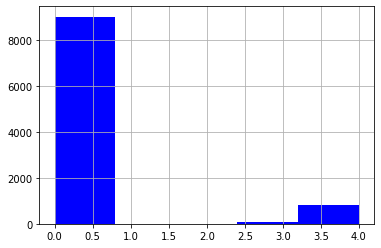

In [83]:
df_submission["prediction"].hist(bins=5,color='blue' )

<AxesSubplot:>

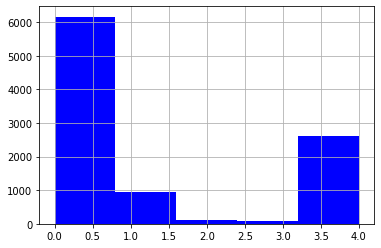

In [84]:
df_submission = pd.DataFrame()
df_submission["userID"] = submission["userID"]
df_submission["itemID"] = submission["itemID"]
df_submission["prediction"] = binarizer.inverse_transform(res_ak)
df_submission["prediction"].hist(bins=5,color='blue' )

In [85]:
df_submission.to_csv(name+"_no_stacking.csv", sep='|')